# Segmentace ledvin prasete domácího z CT snímků

Cílem je automaticky segmentovat zvlášť levou a zvlášť pravou ledvinu.

Odevzdání musí splňovat následující podmínky:
    
 * Kód musí být uložen a dostupný na metacentru ([přihláška](https://metavo.metacentrum.cz/osobniv3/wayf/proxy.jsp?locale=cs&target=https%3A%2F%2Fsignup.e-infra.cz%2Ffed%2Fregistrar%2F%3Fvo%3Dmeta%26locale%3Dcs)) a přístupný pro čtení pro "others"
 * Dejte nám vědět, kde je Váš kód uložen prostřednictvím [formuláře](https://forms.gle/E7TmtVPzqoH9g9US8)
 * Musí obsahovat soubor `run_zdo.py`
 * Musí být spustitelný:
     
         run_zdo.py vstupni_adresar vystupni_adresar


 * všechny soubory s příponou nii.gz jakkoliv vnořené ve vstupním adresáři jsou zpracovány
 * výsledky jsou ve výstupním adresáři, struktura kopíruje vstupní adresár
 * levá ledvina má příponu `.left_kidney.nii.gz` pravá má příponu `.right_kidney.nii.gz`
 * ve výstupním adresáři je rovněž adresář `visualization` ve kterém jsou dokumentovány jednotlivé kroky algoritmu (prahování, filtrace, ...)
 * Doba zpracování jednoho CT nesmí přesáhnout 30s
 
 * Kód musí být uložen na GitHub repozitář (soukromém) a vyučující do něj musí být přidán jako spolupracovník
 * Po uplynutí odevzdání bude kód zveřejněn pod MIT licencí
 
# Data

Data z CT jsou volumetrická, uložená v 3D poli, v souboru `.nii.gz`, kde každý voxel může nabývat kladných i záporných hodnot. Na rozdíl od normálních fotografií jsou hodnoty CT snímků normalizovány a intenzita (rovněž označovaná jako denzita) je měřena v Hounsfieldových jednotkách [HU]. Typické hodnoty jsou:
 * Vzduch: -1000 HU
 * Svaly: 45 HU
 * Kosti: 200 až 1000 HU

# Trocha anatomie


![97a3af7b91f1a2ff656d763d676c82213b6249ee.png](97a3af7b91f1a2ff656d763d676c82213b6249ee.png)
Computed tomography cuts with intravenous contrast in animal 1. (a) transversal section; (b) sagittal section; (c) coronal section; 1: right kidney; 2: left kidney; 3: abdominal aorta; 4: caudal vena cava; 5: right renal vein; 6: left renal vein; 7: liver; 8: small intestine; 9: large intestine; 10: stomach ([převzato z Image-guided study of swine anatomy...](https://doi.org/10.1590/ACB351208))


# Odkazy a inspirace 

 * Pusťte si jupyter notebook na metacentru pomocí služby [on demand](https://ondemand.grid.cesnet.cz/)
 * Zkuste neuronku: [Segment Anything Model](https://colab.research.google.com/drive/1PDyN7siozm25lQYpiDgUocSGMca-fx1W?usp=sharing)
 * [Afinní transformace v io3d](https://github.com/mjirik/io3d/blob/master/examples/affine_transform.ipynb)
 * [Metriky pro 3D segmentaci orgánů](https://github.com/mjirik/imma/blob/master/examples/sliver_evaluation.ipynb)
 * [Anatomie prasete](https://www.scielo.br/j/acb/a/4fCHJrFrtsmh4x46W83VTzr/?lang=en)
 * [Tento notebook na GitHubu](https://github.com/mjirik/zdo2025)

In [1]:
# nastavení přístupu pro others ve dvou krocích (první pro všechny soubory, druhý ještě přidává možnost procházení adresářům)
# chmod -R o+r /cesta/k/adresari
# find /cesta/k/adresari -type d -exec chmod o+x {} \;

In [1]:

%load_ext autoreload
%autoreload 2


# !pip install git+https://github.com/mjirik/io3d --upgrade --force-reinstall 
# !pip install git+https://github.com/mjirik/imma --upgrade --force-reinstall 
    
!pip install git+https://github.com/mjirik/io3d 
!pip install git+https://github.com/mjirik/imma 

!pip install tqdm scikit-image loguru pydicom nibabel

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/mjirik/io3d to /var/tmp/pbs.9137852.pbs-m1.metacentrum.cz/pip-req-build-d0ny5bfv
  Running command git clone --filter=blob:none --quiet https://github.com/mjirik/io3d /var/tmp/pbs.9137852.pbs-m1.metacentrum.cz/pip-req-build-d0ny5bfv
  Resolved https://github.com/mjirik/io3d to commit adcec452fdbf683990c8e8fede1835f5b0e0dfaf
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/mjirik/imma to /var/tmp/pbs.9137852.pbs-m1.metacentrum.cz/pip-req-build-v68m3f2i
  Running command git clone --filter=blob:none --quiet https://github.com/mjirik/imma /var/tmp/pbs.9137852.pbs-m1.metacentrum.cz/pip-req-build-v68m3f2i
  Resolved https://github.com/mjirik/imma to commit 40bb772750dd22ba8d4d97d623ec7b846d8031ca
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-

In [6]:
from pathlib import Path
import os
import io3d
import matplotlib.pyplot as plt
import imma
import numpy as np

In [7]:
dataset_path = Path(os.environ.get("DATA_PP", default="/storage/plzen4-ntis/home/mjirik/data/biomedical/orig/pilsen_pigs_all/transplantation_nii_transposed_zdo"))
assert dataset_path.exists(), "Data not found"

# Process one 3D image

In [8]:
fn = list(dataset_path.glob("**/*.nii.gz"))[0]

In [9]:
datap = io3d.read(fn)
# size of voxel
datap.voxelsize_mm

(0.9017539, 0.9017539, 0.8)

In [10]:
datap.data3d.shape

(512, 512, 677)

## Histogram

Hodnoty kolem -1000 odpovídají vzduchu, zatímco hodnoty kolem nuly odpovídají tkáním.

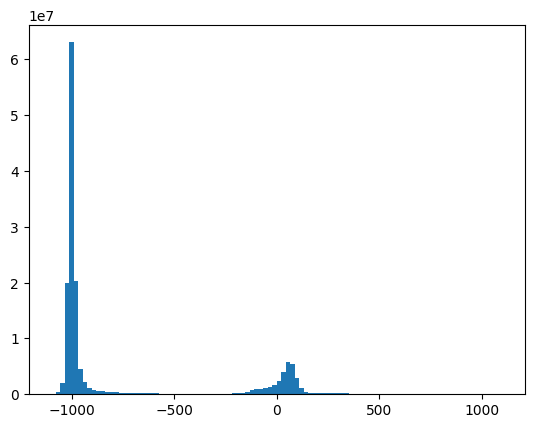

In [15]:
hist_data = plt.hist(datap.data3d.flatten(), bins=100, range=[-1100, 1100])

## Axiální řez

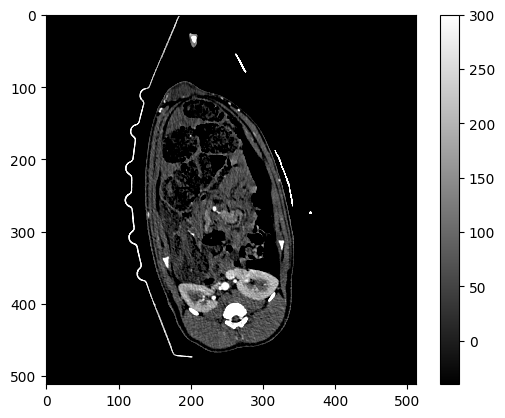

In [8]:
# show i-th slice
i = 400
plt.imshow(datap.data3d[:,:,i], cmap="gray", clim=[-40, 300])
plt.colorbar()
plt.show()

## Předo-zadní řez

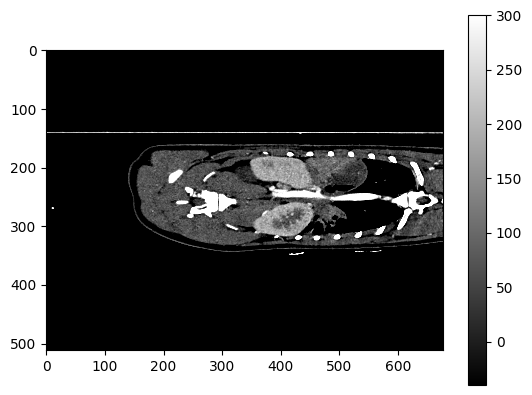

In [10]:
# show i-th slice
i = 380
plt.imshow(datap.data3d[i,:,:], cmap="gray", clim=[-40, 300])
plt.colorbar()
plt.show()

### Max-projection

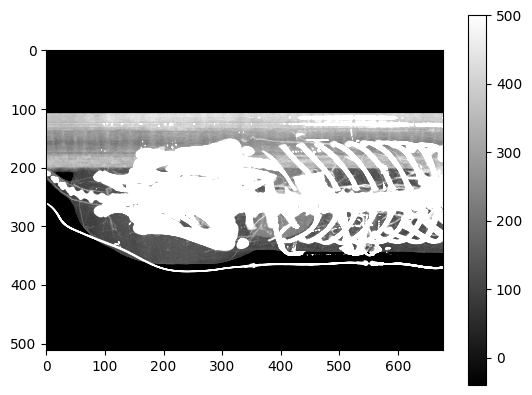

In [13]:
# show i-th slice
i = 380
plt.imshow(np.max(datap.data3d, axis=0), cmap="gray", clim=[-40, 500])
plt.colorbar()
plt.show()

## My segmentation algorithm

In [9]:
seg = datap.data3d > 55

## Fake Ground Truth Segmentation

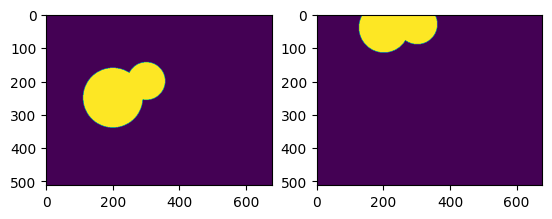

In [10]:
# fake_segmentation = np.zeros_like(dp_liver.data3d)


center = [40, 300, 200]
r = 30

sh = datap.data3d.shape
def make_sphere(r, center, shape):
    sh = shape
    xx,yy,zz = np.meshgrid(list(range(sh[0])), list(range(sh[1])), list(range(sh[2])), indexing='ij')
    fake_gt = (xx-center[0])**2 + (yy-center[1])**2 + (zz-center[2])**2 - r**2
    return fake_gt < 0

sph = make_sphere(90, [40, 250, 200], sh)
sph += make_sphere(60, [30, 200, 300], sh)

fake_gt = sph

 # fake_segmentation = skimage.morphology.ball(30)
# plt.imshow(fake_segmentation[40,:,:])
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fake_gt[50,:,:])
axs[1].imshow(fake_gt[:,200,:], aspect=datap.voxelsize_mm[0]/datap.voxelsize_mm[1])

# Evaluation

Described in paper

Heimann, T., van Ginneken, B., Styner, M. a, Arzhaeva, Y., Aurich, V., Bauer, C., … Wolf, I. (2009). Comparison and evaluation of methods for liver segmentation from CT datasets. IEEE Transactions on Medical Imaging, 28(8), 1251–1265. https://doi.org/10.1109/TMI.2009.2013851

## General metrics independent on volume type
compare_volumes(ground_true, segmentation, voxelsize_mm)

 * `volume1_mm3`: Ground True volume in [mm^3] 
 * `volume2_mm3`: Volume of segmentation in [mm^3]
 * `err1_mm3`: undersegmentation
 * `err2_mm3`: oversegmentation
 * `err1_percent`: undersegmentation in [%]
 * `err2_percent`: oversegmentation in [%]
 * `vd`: Volume difference, negative is means smaller volume of segmentation than ground true
 * `voe`: Volumetric Error
 * `avgd`: Average surface difference

In [11]:
import imma.volumetry_evaluation

In [12]:

evaluation = imma.volumetry_evaluation.compare_volumes(seg, fake_gt, voxelsize_mm = datap.voxelsize_mm)
evaluation

{'volume1_mm3': 10228053.471165419,
 'volume2_mm3': 2026794.5583053827,
 'err1_mm3': 9911946.238706589,
 'err2_mm3': 1710687.3258465528,
 'err1_percent': 161.763674504491,
 'err2_percent': 27.918540021592175,
 'vd': -80.1839659518866,
 'voe': 97.35225650817425,
 'avgd': 189.82053589827342,
 'rmsd': 44977.388003791486,
 'maxd': 448.43003552519144,
 'dice': 0.9484110726304159,
 'jaccard': 0.026477434918257478}